# Задание 1

Опишите задачу с точки зрения NLP. Что это за задача, какие классические методы существуют для ее решения? Как ее можно решать через LLM? Как обычно оценивают качество моделей в этой задаче?


Это задача распознавания именных сущностей(Named entity recognition NER), задача nlp, где мы пытаемся в тексте понять, где находятся имена/номера домов/названия организаций/ и т.д.

Классические методы решения NER включают:

* Подходы, основанные на правилах: с помощью регулярок/шаблонов/лингвистических признаков.
* На основе машинного обучения: Модели, например BERT, обучаются на размеченных данных, чтобы после обучения они сами могли распознавать именованные сущности.
* Гибридные подходы: Могут сначала использоваться подходы на основе правил, а после на основе ml для уточнения.

Для оценки качества можно использовать метрики, как precision, recall, f-мера


# Задание 2
Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer". 

In [1]:
from corus import load_bsnlp  # я сначала сам пытался прочитать файлы, но нашел замечательную либу, которая за меня это сделает

path = '../data'  # путь к датасетам
doc_id = []
doc_text = []
full_entity = []
full_gold = []
records = load_bsnlp(path)
for record in records:
    gold_answer = []
    entity = []
    doc_id.append(record.id)
    doc_text.append(record.text)
    for ner in record.substrings:
        if ner.type not in entity:
            entity.append(ner.type)
        if f'{ner.type}-{ner.normal}' not in gold_answer:
            gold_answer.append(f'{ner.type}-{ner.normal}')
    full_entity.append(', '.join(entity))
    full_gold.append(', '.join(sorted(gold_answer)))

In [2]:
import pandas as pd

data = pd.DataFrame({
    'document_id': doc_id,
    'document_text': doc_text,
    'entity': full_entity,
    'gold_answer': full_gold
})


In [3]:
data.head()

,document_id,document_text,entity,gold_answer
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,"EVT, LOC, PER, ORG","EVT-Brexit, EVT-брекзит, EVT-брексит, LOC-Альб..."
1,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, ORG-ЕС, ORG-МИ..."
2,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...,"ORG, EVT, PER, LOC","EVT-Brexit, LOC-Великобритания, LOC-Соединенно..."
3,ru-1002,09.07.2018 18:09 : Премьер-министр Великобрита...,"PER, EVT, LOC, ORG","EVT-Брекзит, LOC-Великобритания, ORG-ЕС, ORG-Е..."
4,ru-1003,09.07.2018 17:02 : Министр иностранных дел Вел...,"PER, LOC, ORG, EVT","EVT-брекзит, LOC-Великобритания, LOC-Даунинг-С..."


# Задание 3
Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.

In [4]:
def for_llm(row):
    return f"""Вы - передовая система распознавания именованных сущностей (NER). Ваша задача — идентифицировать следующие категории: PER(личности), ORG(организации), LOC(места), EVT(события), PRO(продукты). Ниже дан текст, найдите все именованные сущности по порядку. Ищите так, как будто от этого зависит чья-то жизнь. Используй только те сущности, которые есть в тексте.  
Соблюдайте следующий формат ответа: PRO-название продукта, ORG-название организации, PER-имя, EVT-название мероприятия, LOC-место/страна
Текст: {row['document_text']}
"""


In [5]:
prompts = []
for index, row in data.iterrows():
    prompts.append(for_llm(row))

data['prompt'] = prompts

# Задание 4

Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.
Внесите ответы GigaChat в датафрейм, сохраните его.


In [6]:
to_df = []

In [7]:
# ru-10
llm_response = """PER-Тереза Мэй, Борис Джонсон, Себастьян Курц, Мишель Барнье
ORG-Консервативная партия, Европейский Союз, Международный валютный фонд, Еврокомиссия
EVT-конференция тори, экстренный саммит Евросоюза
LOC-Британия, Северная Ирландия, Брюссель"""
llm_response = llm_response.split('\n')
one_doc = []
for line in llm_response:
    line = line.split(', ')
    for i, named_entity in enumerate(line):
        if i == 0:
            try:
                _entity = named_entity[:3]
                one_doc.append(named_entity)
                continue
            except:
                _entity = 'UNK'
        if f'{_entity}-{named_entity}' not in one_doc:
            one_doc.append(f'{_entity}-{named_entity}')
to_df.append(', '.join(sorted(one_doc)))

In [8]:
# ru-1000
llm_response = """PER-Борис Джонсон, Тереза Мэй, Дэвид Дэвис, Стив Бейкер
ORG-Подробности.ua, The Guardian, УНН, британский парламент"""
llm_response = llm_response.split('\n')
one_doc = []
for line in llm_response:
    line = line.split(', ')
    for i, named_entity in enumerate(line):
        if i == 0:
            try:
                _entity = named_entity[:3]
                one_doc.append(named_entity)
                continue
            except:
                _entity = 'UNK'
        if f'{_entity}-{named_entity}' not in one_doc:
            one_doc.append(f'{_entity}-{named_entity}')
to_df.append(', '.join(sorted(one_doc)))

In [9]:
# ru-1001
llm_response = """PER-Борис Джонсон, PER-Тереза Мэй, ORG-МИД Британии, ORG-Associated Press, ORG-канцелярия премьера"""
to_df.append(', '.join(sorted(llm_response.split(', '))))

In [10]:
# ru-1002
llm_response = """PER-Тереза Мей, Борис Джонсон, Дэвид Дэвис"""
llm_response = llm_response.split('\n')
one_doc = []
for line in llm_response:
    line = line.split(', ')
    for i, named_entity in enumerate(line):
        if i == 0:
            try:
                _entity = named_entity[:3]
                one_doc.append(named_entity)
                continue
            except:
                _entity = 'UNK'
        if f'{_entity}-{named_entity}' not in one_doc:
            one_doc.append(f'{_entity}-{named_entity}')
to_df.append(', '.join(sorted(one_doc)))

In [11]:
# ru-1003
llm_response = """PER-Борис Джонсон, Тереза Мэй, Дэвид Дэвис
ORG-Министерство иностранных дел Великобритании, агентство Рейтер, Даунинг-Стрит"""
llm_response = llm_response.split('\n')
one_doc = []
for line in llm_response:
    line = line.split(', ')
    for i, named_entity in enumerate(line):
        if i == 0:
            try:
                _entity = named_entity[:3]
                one_doc.append(named_entity)
                continue
            except:
                _entity = 'UNK'
        if f'{_entity}-{named_entity}' not in one_doc:
            one_doc.append(f'{_entity}-{named_entity}')
to_df.append(', '.join(sorted(one_doc)))

In [12]:
# ru-1004
llm_response = """PER-Борис Джонсон, Тереза Мэй, Дэвид Дэвис
ORG-МИД Великобритании, канцелярия премьер-министра, Консервативная партия
EVT-отставка, саммит по развитию региона Западных Балкан
LOC-Великобритания, Евросоюз"""
llm_response = llm_response.split('\n')
one_doc = []
for line in llm_response:
    line = line.split(', ')
    for i, named_entity in enumerate(line):
        if i == 0:
            try:
                _entity = named_entity[:3]
                one_doc.append(named_entity)
                continue
            except:
                _entity = 'UNK'
        if f'{_entity}-{named_entity}' not in one_doc:
            one_doc.append(f'{_entity}-{named_entity}')
to_df.append(', '.join(sorted(one_doc)))

In [13]:
# ru-1006
llm_response = """PER-Мария Захарова, Борис Джонсон, Тереза Мэй
ORG-МИД России, правительство Великобритании
EVT-отставка, правительственный кризис, Brexit"""
llm_response = llm_response.split('\n')
one_doc = []
for line in llm_response:
    line = line.split(', ')
    for i, named_entity in enumerate(line):
        if i == 0:
            try:
                _entity = named_entity[:3]
                one_doc.append(named_entity)
                continue
            except:
                _entity = 'UNK'
        if f'{_entity}-{named_entity}' not in one_doc:
            one_doc.append(f'{_entity}-{named_entity}')
to_df.append(', '.join(sorted(one_doc)))

In [14]:
# ru-1011
llm_response = """PER-Борис Джонсон, Тереза Мэй, Дэвид Дэвис
ORG-британская пресса, правительство Великобритании
EVT-отставка министра иностранных дел Великобритании, отставка министра по выходу Великобритании из ЕС, отставка Терезы Мэй, представление стратегии выхода страны из Евросоюза
PRO-Brexit"""
llm_response = llm_response.split('\n')
one_doc = []
for line in llm_response:
    line = line.split(', ')
    for i, named_entity in enumerate(line):
        if i == 0:
            try:
                _entity = named_entity[:3]
                one_doc.append(named_entity)
                continue
            except:
                _entity = 'UNK'
        if f'{_entity}-{named_entity}' not in one_doc:
            one_doc.append(f'{_entity}-{named_entity}')
to_df.append(', '.join(sorted(one_doc)))

In [15]:
# ru-1017
llm_response = """Как у нейросетевой языковой модели у меня не может быть настроения, но почему-то я совсем не хочу говорить на эту тему.
"""
llm_response = llm_response.split('\n')
one_doc = []
for line in llm_response:
    line = line.split(', ')
    for i, named_entity in enumerate(line):
        if i == 0:
            try:
                _entity = named_entity[:3]
                one_doc.append(named_entity)
                continue
            except:
                _entity = 'UNK'
        if f'{_entity}-{named_entity}' not in one_doc:
            one_doc.append(f'{_entity}-{named_entity}')
to_df.append(', '.join(sorted(one_doc)))

In [16]:
data['predict'] = to_df
data

,document_id,document_text,entity,gold_answer,prompt,predict
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,"EVT, LOC, PER, ORG","EVT-Brexit, EVT-брекзит, EVT-брексит, LOC-Альб...",Вы - передовая система распознавания именованн...,"EVT-конференция тори, EVT-экстренный саммит Ев..."
1,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, ORG-ЕС, ORG-МИ...",Вы - передовая система распознавания именованн...,"ORG-The Guardian, ORG-Подробности.ua, ORG-УНН,..."
2,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...,"ORG, EVT, PER, LOC","EVT-Brexit, LOC-Великобритания, LOC-Соединенно...",Вы - передовая система распознавания именованн...,"ORG-Associated Press, ORG-МИД Британии, ORG-ка..."
3,ru-1002,09.07.2018 18:09 : Премьер-министр Великобрита...,"PER, EVT, LOC, ORG","EVT-Брекзит, LOC-Великобритания, ORG-ЕС, ORG-Е...",Вы - передовая система распознавания именованн...,"PER-Борис Джонсон, PER-Дэвид Дэвис, PER-Тереза..."
4,ru-1003,09.07.2018 17:02 : Министр иностранных дел Вел...,"PER, LOC, ORG, EVT","EVT-брекзит, LOC-Великобритания, LOC-Даунинг-С...",Вы - передовая система распознавания именованн...,"ORG-Даунинг-Стрит, ORG-Министерство иностранны..."
5,ru-1004,Борис Джонсон ушел в отставку с поста главы МИ...,"EVT, PER, LOC, ORG","EVT-Brexit, LOC-Германия, LOC-Западные Балканы...",Вы - передовая система распознавания именованн...,"EVT-отставка, EVT-саммит по развитию региона З..."
6,ru-1006,Захарова лирически прокомментировала отставку ...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Британия, LOC-Великобритания, ...",Вы - передовая система распознавания именованн...,"EVT-Brexit, EVT-отставка, EVT-правительственны..."
7,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, ORG-ЕС, ORG-Ев...",Вы - передовая система распознавания именованн...,"EVT-отставка Терезы Мэй, EVT-отставка министра..."
8,ru-1017,Борис Джонсон подал в отставку с поста министр...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, LOC-КИЕВ, ORG-...",Вы - передовая система распознавания именованн...,", Как у нейросетевой языковой модели у меня не..."


In [17]:
data.to_csv('result.csv')

# Задание 5

Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float. Можно пользоваться только библиотеками numpy, scipy, pandas. Напишите юнит-тесты. Возможно ли ускорить вычисление функции через векторную реализацию? Поясните решение и обоснуйте, почему выбрали именно такую метрику.

In [18]:
def score_fn(gold: str, pred: str) -> float:
    gold_entities = [entity.strip() for entity in gold.split(', ')]
    pred_entities = [entity.strip() for entity in pred.split(', ')]
    n = 1
    if gold == "" or pred == "" or gold_entities is [] or pred_entities is []:
        return 0.0
    tp = 0
    for entity_name in pred_entities:
        if entity_name in gold_entities:
            tp += 1

    if tp == 0:
        return 0

    precision = tp / len(pred_entities)
    recall = tp / len(gold_entities)

    f_score = ((1 + n ** 2) * precision * recall) / (n ** 2 * precision + recall)

    return f_score


Не уверен, что получится реализовать векторную реализацию ввиду не самой удобной реализации хранения данных.

# unittest

In [19]:
import unittest

class TestScoreFn(unittest.TestCase):
    def test_no_matches(self):
        self.assertEqual(score_fn("entity1, entity2", "entity3, entity4"), 0.0)
        self.assertEqual(score_fn("entity1", "entity2"), 0.0)

    def test_perfect_matches(self):
        self.assertEqual(score_fn("entity1, entity2, entity3", "entity1, entity2, entity3"), 1.0)
        self.assertEqual(score_fn("entity1", "entity1"), 1.0)

    def test_empty(self):
        self.assertEqual(score_fn("", ""), 0.0)
        self.assertEqual(score_fn("", "entity1, entity2"), 0.0)
        self.assertEqual(score_fn("entity1, entity2", ""), 0.0)

    def test_partial_matches(self):
        self.assertAlmostEqual(score_fn("entity1, entity2, entity3", "entity1, entity3"), 0.8)
        self.assertAlmostEqual(score_fn("entity1, entity2", "entity1, entity2, entity3"), 0.8)

unittest.main(argv=[''], verbosity=2, exit=False)


test_empty (__main__.TestScoreFn.test_empty) ... ok
test_no_matches (__main__.TestScoreFn.test_no_matches) ... ok
test_partial_matches (__main__.TestScoreFn.test_partial_matches) ... ok
test_perfect_matches (__main__.TestScoreFn.test_perfect_matches) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.002s

OK


# Задание 6
Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты 
* по каждой сущности 
* по каждому документу. 

* по каждой сущности

In [20]:
def fn_score_by_entity(gold, pred, entity, n=None):
    gold_entities = [label.strip() for label in gold.split(', ') if entity in label[:3]]
    pred_entities = [label.strip() for label in pred.split(', ') if entity in label[:3]]
    if n is None:
        n = 1

    tp = 0
    for entity_name in pred_entities:
        if entity_name in gold_entities:
            tp += 1

    if tp == 0:
        return 0.0

    precision = tp / len(pred_entities)
    recall = tp / len(gold_entities)

    f_score = ((1 + n ** 2) * precision * recall) / (n ** 2 * precision + recall)
    return f_score

In [21]:
entities = ["EVT", "LOC", "ORG", "PER", "PRO"]

for entity in entities:
    data[f'fn_{entity}'] = data.apply(lambda x: fn_score_by_entity(x['gold_answer'], x['predict'], entity), axis=1)

data

,document_id,document_text,entity,gold_answer,prompt,predict,fn_EVT,fn_LOC,fn_ORG,fn_PER,fn_PRO
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,"EVT, LOC, PER, ORG","EVT-Brexit, EVT-брекзит, EVT-брексит, LOC-Альб...",Вы - передовая система распознавания именованн...,"EVT-конференция тори, EVT-экстренный саммит Ев...",0.0,0.545455,0.461538,0.727273,0.0
1,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, ORG-ЕС, ORG-МИ...",Вы - передовая система распознавания именованн...,"ORG-The Guardian, ORG-Подробности.ua, ORG-УНН,...",0.0,0.000000,0.285714,0.800000,0.0
2,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...,"ORG, EVT, PER, LOC","EVT-Brexit, LOC-Великобритания, LOC-Соединенно...",Вы - передовая система распознавания именованн...,"ORG-Associated Press, ORG-МИД Британии, ORG-ка...",0.0,0.000000,0.500000,0.571429,0.0
3,ru-1002,09.07.2018 18:09 : Премьер-министр Великобрита...,"PER, EVT, LOC, ORG","EVT-Брекзит, LOC-Великобритания, ORG-ЕС, ORG-Е...",Вы - передовая система распознавания именованн...,"PER-Борис Джонсон, PER-Дэвид Дэвис, PER-Тереза...",0.0,0.000000,0.000000,1.000000,0.0
4,ru-1003,09.07.2018 17:02 : Министр иностранных дел Вел...,"PER, LOC, ORG, EVT","EVT-брекзит, LOC-Великобритания, LOC-Даунинг-С...",Вы - передовая система распознавания именованн...,"ORG-Даунинг-Стрит, ORG-Министерство иностранны...",0.0,0.000000,0.000000,0.750000,0.0
5,ru-1004,Борис Джонсон ушел в отставку с поста главы МИ...,"EVT, PER, LOC, ORG","EVT-Brexit, LOC-Германия, LOC-Западные Балканы...",Вы - передовая система распознавания именованн...,"EVT-отставка, EVT-саммит по развитию региона З...",0.0,0.000000,0.444444,0.666667,0.0
6,ru-1006,Захарова лирически прокомментировала отставку ...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Британия, LOC-Великобритания, ...",Вы - передовая система распознавания именованн...,"EVT-Brexit, EVT-отставка, EVT-правительственны...",0.5,0.000000,0.666667,0.444444,0.0
7,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, ORG-ЕС, ORG-Ев...",Вы - передовая система распознавания именованн...,"EVT-отставка Терезы Мэй, EVT-отставка министра...",0.0,0.000000,0.000000,0.666667,0.0
8,ru-1017,Борис Джонсон подал в отставку с поста министр...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, LOC-КИЕВ, ORG-...",Вы - передовая система распознавания именованн...,", Как у нейросетевой языковой модели у меня не...",0.0,0.000000,0.000000,0.000000,0.0


* по каждому документу

In [22]:
scores = data.apply(lambda x: score_fn(x['gold_answer'], x['predict']), axis=1)
data['scores'] = scores
data

,document_id,document_text,entity,gold_answer,prompt,predict,fn_EVT,fn_LOC,fn_ORG,fn_PER,fn_PRO,scores
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,"EVT, LOC, PER, ORG","EVT-Brexit, EVT-брекзит, EVT-брексит, LOC-Альб...",Вы - передовая система распознавания именованн...,"EVT-конференция тори, EVT-экстренный саммит Ев...",0.0,0.545455,0.461538,0.727273,0.0,0.500000
1,ru-1000,Подробности.ua: Третий за сутки: Борис Джонсон...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, ORG-ЕС, ORG-МИ...",Вы - передовая система распознавания именованн...,"ORG-The Guardian, ORG-Подробности.ua, ORG-УНН,...",0.0,0.000000,0.285714,0.800000,0.0,0.476190
2,ru-1001,Глава МИД Британии Борис Джонсон подал в отста...,"ORG, EVT, PER, LOC","EVT-Brexit, LOC-Великобритания, LOC-Соединенно...",Вы - передовая система распознавания именованн...,"ORG-Associated Press, ORG-МИД Британии, ORG-ка...",0.0,0.000000,0.500000,0.571429,0.0,0.444444
3,ru-1002,09.07.2018 18:09 : Премьер-министр Великобрита...,"PER, EVT, LOC, ORG","EVT-Брекзит, LOC-Великобритания, ORG-ЕС, ORG-Е...",Вы - передовая система распознавания именованн...,"PER-Борис Джонсон, PER-Дэвид Дэвис, PER-Тереза...",0.0,0.000000,0.000000,1.000000,0.0,0.600000
4,ru-1003,09.07.2018 17:02 : Министр иностранных дел Вел...,"PER, LOC, ORG, EVT","EVT-брекзит, LOC-Великобритания, LOC-Даунинг-С...",Вы - передовая система распознавания именованн...,"ORG-Даунинг-Стрит, ORG-Министерство иностранны...",0.0,0.000000,0.000000,0.750000,0.0,0.375000
5,ru-1004,Борис Джонсон ушел в отставку с поста главы МИ...,"EVT, PER, LOC, ORG","EVT-Brexit, LOC-Германия, LOC-Западные Балканы...",Вы - передовая система распознавания именованн...,"EVT-отставка, EVT-саммит по развитию региона З...",0.0,0.000000,0.444444,0.666667,0.0,0.370370
6,ru-1006,Захарова лирически прокомментировала отставку ...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Британия, LOC-Великобритания, ...",Вы - передовая система распознавания именованн...,"EVT-Brexit, EVT-отставка, EVT-правительственны...",0.5,0.000000,0.666667,0.444444,0.0,0.421053
7,ru-1011,За Борисом Джонсоном последует сама Мэй - брит...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, ORG-ЕС, ORG-Ев...",Вы - передовая система распознавания именованн...,"EVT-отставка Терезы Мэй, EVT-отставка министра...",0.0,0.000000,0.000000,0.666667,0.0,0.272727
8,ru-1017,Борис Джонсон подал в отставку с поста министр...,"EVT, PRO, PER, LOC, ORG","EVT-Brexit, LOC-Великобритания, LOC-КИЕВ, ORG-...",Вы - передовая система распознавания именованн...,", Как у нейросетевой языковой модели у меня не...",0.0,0.000000,0.000000,0.000000,0.0,0.000000


Изобразите результаты на графиках. Какие выводы можно сделать?

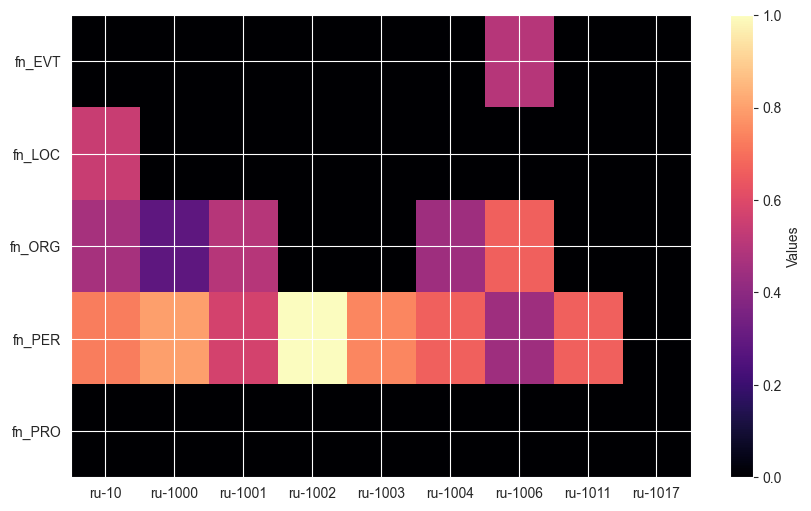

In [23]:
import matplotlib.pyplot as plt


columns = [col for col in data.columns if col[:2] == 'fn']
result = {'document_id': data['document_id']}
for i in range(len(columns)):
    result[columns[i]] = data[columns[i]].tolist()

result = pd.DataFrame(result)
result.set_index('document_id', inplace=True)
plt.figure(figsize=(10, 6))
plt.imshow(result.T, cmap='magma', aspect='auto')
plt.yticks(range(len(result.columns)), result.columns)
plt.xticks(range(len(result.index)), result.index)
plt.colorbar(label='Values')
plt.show()

<Axes: xlabel='document_id', ylabel='scores'>

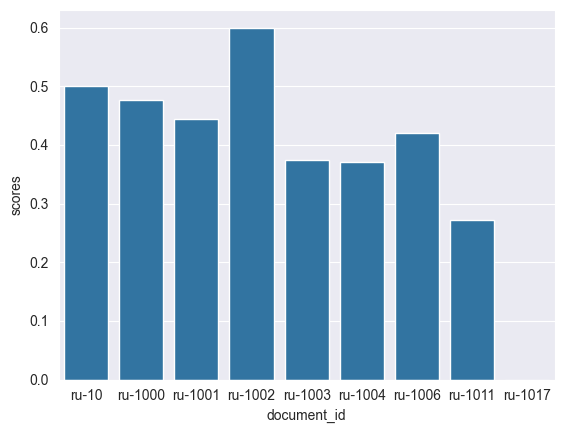

In [24]:
import seaborn as sns

sns.barplot(x='document_id', y='scores', data=data)

ru-1017 невозможно оценить ввиду блока ответа от gigachat, возможно можно было бы обойти это путем запроса через gigachain и profanity_check=false, но это уже совсем другая история

Продукты(PRO), Ивенты(EVT) и Локации(LOC) плохо распознает

# Задание 7
Есть ли зависимость метрик от длины документа? Постройте графики, чтобы ответить на вопрос.

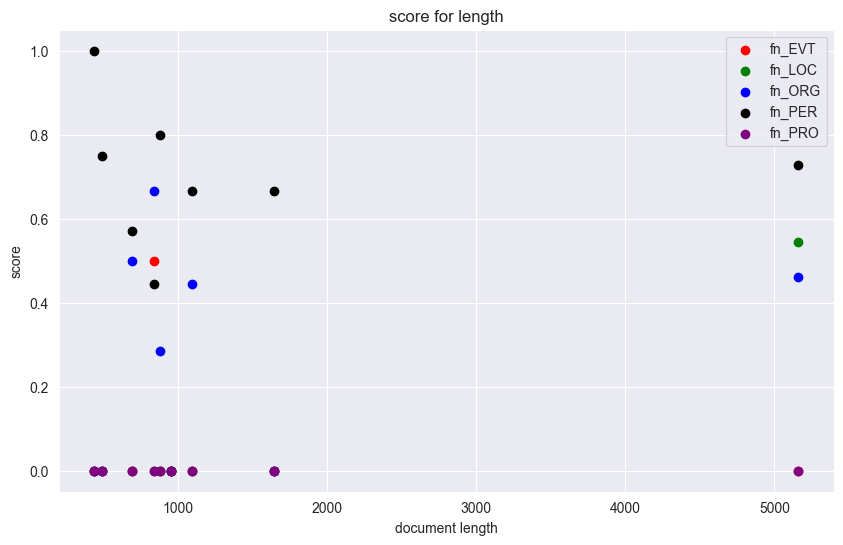

In [25]:
columns = [col for col in data.columns if col[:2] == 'fn']
doc_lengths = data['document_text'].apply(len)

colors = ['red', 'green', 'blue', 'black', 'purple']
plt.figure(figsize=(10, 6))
for columns, color in zip(columns, colors):
    plt.scatter(x=doc_lengths, y=data[columns], label=columns, color=color)


plt.legend()
plt.xlabel('document length')
plt.ylabel('score')
plt.title('score for length')

plt.show()

Я предполагаю, что да, от длинны документа score будет зависить. Если предобработать текст(стоп слова, знаки препинания), посылать в LLM его кусками, например предложениями, то из-за того, что текст будет небольшими кусочками, то он будет распознавать в предложении все именованные сущности

# Задание 8
Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.

LLM неплохо справляется идентификацией PER, но при этом абсолютно плохо выходит с PRO, чуть менее плохо получается EVT и LOC

* Путает ORG и PRO(Считает, что это ORG, а на самом деле это PRO)
* Путает ORG и LOC(Считает, что это LOC, а на самом деле это ORG и иногда наоборот)
* Много ложных ивентов, он считает это скорее неким действием, а не событием

Если предобработать текст, посылать в LLM его кусками, например предложениями, то из-за того, что текст будет небольшими кусочками, то он будет распознавать в предложении все именованные сущности.

И самое главное, что мы считаем gold answer, надо четко прописывать в промпте, что такое gold answer. Я думал использовать как-то `cross-lingual ID`, но достаточно сложно жать понять модели, что такое `cross-lingual ID`


Из-за особенностей политической новости ru-1017, gigachat не захотел ответить на нее. Иногда с определенным one/few-shot промптом, не хотел отвечать на другие документы, хотя с другим/без промптом/промпта он отвечал. Получается, он иногда находил какую-то `нехорошую` тему связывая шаблон и текст новости.


## Результаты детекции сущностей:
- Сущности типа EVT детектировались неправильно, часто вместо действительно EVT он выдавал на ответ какие-то действия, например `EVT-отставка Терезы Мэй, EVT-отставка министра иностранных дел Великобритании`. Тут точно нужно пробовать разные промпты и возможно нужна модель более строгая к инструкциям(например gpt-instruct)
- Сущности PER детектировались хорошо.
- Встречались ошибки в метках, например,

| Надо               | Получилось         |
|--------------------|--------------------|
| `ORG-The Guardian` | `PRO-The Guardian` |
| `ORG-Евросоюз`     | `LOC-Евросоюз`     |


Переформулировка промпта может помочь в решении этой проблемы.


## Предложения по улучшению:
- Разобраться, что такое `gold answer`
- Предобработать текст
- Более строгую модель к инструкциям

# Задание 9
Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.

В ходе работы над тестовым я глубже познакомился с задачей NER. Я знал об этой задаче, но знания ограничивались тем, что существуют инструменты deeppavlov и spaCy. И что можно тратить токены LLM на это, но как будто не выгодно на такое тратить их.

Изучил возможность применения GigaChat для решения задачи NER и в общем автоматизации каких-то рутинных задач.

Более подробно разобрался в юнит-тестах. Знал про низ, но опять же, ввиду специфики работы, никогда не приходилось их писать.